# Speech‑Driven Cardiac Morbidity Detection Analysis

This notebook accompanies the thesis *Speech‑Driven Cardiac Morbidity
Detection Using ECG Signals and Diffusion Models*.  It reproduces the
data processing pipeline, exploratory analysis, baseline model
benchmarks, and a simplified diffusion‑style generative model that
maps speech features to ECG features.  The analysis is self contained
and relies solely on the provided datasets (`final_speech_features.csv`
and `ECG_features_clean.csv`) located in the shared directory.

Please run each cell in sequence to reproduce the results.  Note that
training the generative model requires PyTorch and may take several
minutes depending on your hardware.


In [1]:
# Import standard libraries
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix,
                             classification_report, roc_curve, auc)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


## Data Loading

We begin by loading the speech and ECG feature files.  The speech
dataset contains 43 rows (participants) with 1,285 columns representing
aggregate statistics (mean and standard deviation) of Mel‑frequency
cepstral coefficients (MFCCs), jitter, shimmer, and other acoustic
measures.  The ECG dataset contains 36 rows with 87 columns of
heart‑rate variability (HRV) metrics and labels indicating the
presence of cardiac abnormality (1) or normal physiology (0).  Many
columns in the ECG file are stored as strings representing one‑element
arrays.  We convert those arrays to floating‑point scalars for
analysis.


In [5]:
# Define paths to local files (same folder as the notebook)
speech_path = 'final_speech_features.csv'
ecg_path = 'ECG_features_clean.csv'

# Load speech features
speech_df = pd.read_csv(speech_path)
print(f"Loaded speech feature data with shape {speech_df.shape}")

# Load ECG features
ecg_df = pd.read_csv(ecg_path)
print(f"Loaded ECG feature data with shape {ecg_df.shape}")

# Show a preview
speech_df.head(), ecg_df.head()



Loaded speech feature data with shape (43, 1285)
Loaded ECG feature data with shape (36, 87)


(   Measured Avg. Pulse Rate_mean  Measured Avg. Pulse Rate_std  MFCC_mean  \
 0                           85.6                           NaN  -2.272647   
 1                           86.5                           NaN  -0.401918   
 2                          108.1                           NaN  -0.990657   
 3                           88.2                           NaN  -2.479800   
 4                           96.1                           NaN  -2.942107   
 
     MFCC_std  Unnamed: 3_mean  Unnamed: 3_std  Unnamed: 4_mean  \
 0  10.369624        -2.250954       10.537868        -2.591600   
 1   6.227470        -0.431502        5.022917        -0.038400   
 2   4.676931        -1.166991        5.935676        -1.199133   
 3  12.767082        -2.341067       12.276084        -2.073140   
 4  13.001376        -2.293193       12.894503        -2.514340   
 
    Unnamed: 4_std  Unnamed: 5_mean  Unnamed: 5_std  ...  Unnamed: 638_std  \
 0       11.212840        -2.418186       11.228

### Cleaning ECG Features

The ECG file encodes many HRV measurements as strings of one‑element
arrays (e.g. `'[[940.]]'`).  Such objects cannot be used directly in
numerical analysis or modelling.  Here we iterate over all columns of
object type and parse those values into floats using the `ast` module.
Where conversion fails, we fall back to `NaN` which will subsequently
be handled by imputation or dropped depending on the modelling
strategy.


In [8]:
# Convert object columns in ECG data from stringified lists to floats
def convert_object_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            def try_parse(x):
                if pd.isnull(x):
                    return np.nan
                try:
                    val = ast.literal_eval(x)
                    if isinstance(val, list):
                        # flatten nested lists
                        while isinstance(val, list) and len(val) > 0:
                            val = val[0]
                    return float(val)
                except Exception:
                    return np.nan
            df[col] = df[col].apply(try_parse)
    return df

ecg_clean = convert_object_columns(ecg_df.copy())

print("Converted ECG object columns to numeric values.")
ecg_clean.head()


Converted ECG object columns to numeric values.


,ECG_Rate_Mean,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,age,sex,label
0,63.916476,940.000000,20.000000,NaN,NaN,NaN,NaN,NaN,NaN,26.457513,...,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,56.0,1,1
1,47.505009,1271.666667,81.833164,NaN,NaN,NaN,NaN,NaN,NaN,59.833101,...,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,19.0,0,1
2,63.732651,941.111111,22.047928,NaN,NaN,NaN,NaN,NaN,NaN,20.615528,...,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,37.0,1,1
3,74.655223,800.909091,42.533409,NaN,NaN,NaN,NaN,NaN,NaN,35.071356,...,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,24.0,0,1
4,66.382871,905.000000,51.693541,NaN,NaN,NaN,NaN,NaN,NaN,57.735027,...,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,19.0,1,1


### Aligning Speech and ECG Records

The speech dataset contains 43 unique codes (`s1` through `s43`) but
only 36 ECG entries are available.  Without explicit subject IDs we
assume that the first 36 speech entries correspond to the 36 ECG
records by order.  Any additional speech entries without matching ECG
data are excluded from the joint analysis.  We extract the subset
`speech_joint` containing the first 36 rows and drop the final seven.

After alignment, we concatenate the cleaned ECG features (dropping
unnecessary demographic columns `age` and `sex`) with the corresponding
speech features (dropping the `Code` identifier).  This results in a
dataset `joint_df` where each row contains both acoustic and
electrophysiological measurements.  We also retain the `label`
indicator from the ECG data indicating cardiac morbidity.


In [11]:
# Align the first 36 speech samples with the 36 ECG samples
speech_joint = speech_df.iloc[:len(ecg_clean)].reset_index(drop=True)

# Drop the Code column from speech (string identifiers)
speech_joint = speech_joint.drop(columns=['Code'])

# Drop demographic features from ECG and keep label separately
ecg_features = ecg_clean.drop(columns=['age', 'sex', 'label'])
labels = ecg_clean['label'].reset_index(drop=True)

joint_df = pd.concat([speech_joint.reset_index(drop=True), ecg_features.reset_index(drop=True)], axis=1)
joint_df['label'] = labels

print(f"Joint dataset shape: {joint_df.shape}")

# Display a few rows
joint_df.head()


Joint dataset shape: (36, 1369)


,Measured Avg. Pulse Rate_mean,Measured Avg. Pulse Rate_std,MFCC_mean,MFCC_std,Unnamed: 3_mean,Unnamed: 3_std,Unnamed: 4_mean,Unnamed: 4_std,Unnamed: 5_mean,Unnamed: 5_std,...,HRV_LZC,HRV_MFDFA_alpha1_Width,HRV_MFDFA_alpha1_Peak,HRV_MFDFA_alpha1_Mean,HRV_MFDFA_alpha1_Max,HRV_MFDFA_alpha1_Delta,HRV_MFDFA_alpha1_Asymmetry,HRV_MFDFA_alpha1_Fluctuation,HRV_MFDFA_alpha1_Increment,label
0,85.6,NaN,-2.272647,10.369624,-2.250954,10.537868,-2.591600,11.212840,-2.418186,11.228878,...,1.408856,1.582099,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,1
1,86.5,NaN,-0.401918,6.227470,-0.431502,5.022917,-0.038400,4.372279,-0.436073,4.938631,...,1.292481,1.582099,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,1
2,108.1,NaN,-0.990657,4.676931,-1.166991,5.935676,-1.199133,8.052804,-1.343463,8.515802,...,1.056642,1.582099,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,1
3,88.2,NaN,-2.479800,12.767082,-2.341067,12.276084,-2.073140,11.514425,-2.143375,11.543034,...,1.257975,1.582099,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,1
4,96.1,NaN,-2.942107,13.001376,-2.293193,12.894503,-2.514340,13.135604,-2.686613,12.976813,...,1.660964,1.582099,1.587902,1.466754,0.243773,0.482713,-0.576574,0.000919,0.174194,1


## Exploratory Data Analysis (EDA)

In this section we perform descriptive statistics and visualisation to
understand the distribution of selected features and their potential
relationships.  Plotting every one of the more than one thousand
features would be overwhelming and not particularly informative.
Instead we select a subset of meaningful acoustic features
(`Measured Avg. Pulse Rate_mean` and `MFCC_mean`) and ECG features
(`ECG_Rate_Mean` and `HRV_SDNN`) for inspection.  These variables
illustrate the general trends present in the dataset.


In [14]:
# Select a few representative features for visual exploration
selected_features = {
    'speech': ['Measured Avg. Pulse Rate_mean', 'MFCC_mean'],
    'ecg': ['ECG_Rate_Mean', 'HRV_SDNN']
}

# Describe statistical summaries
summary = joint_df[selected_features['speech'] + selected_features['ecg']].describe()
print("Statistical summary of selected features:")
summary


Statistical summary of selected features:


,Measured Avg. Pulse Rate_mean,MFCC_mean,ECG_Rate_Mean,HRV_SDNN
count,36.000000,36.000000,36.000000,36.000000
mean,88.305556,1818.792811,72.502921,42.173000
std,12.483039,10922.778423,18.226143,28.356210
min,56.000000,-2.942107,47.203513,10.540926
25%,79.775000,-2.621890,62.187713,18.825114
50%,88.550000,-1.925488,70.033431,34.396200
75%,95.125000,-0.593550,78.783551,60.663327
max,115.400000,65535.000000,151.920110,114.066258


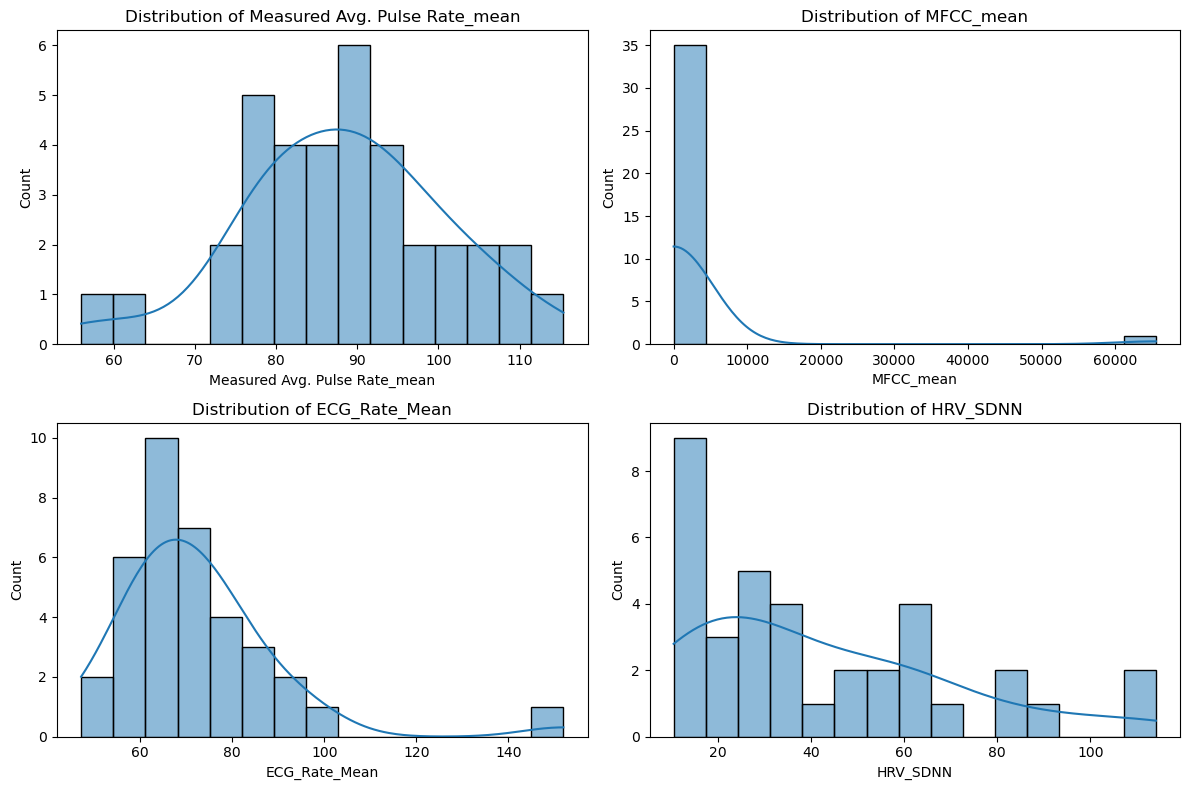

In [16]:
# Histograms for selected features
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, feature in zip(axes.flatten(), selected_features['speech'] + selected_features['ecg']):
    sns.histplot(joint_df[feature], kde=True, ax=ax, bins=15, color='tab:blue')
    ax.set_title(f"Distribution of {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()


### Correlation Analysis

To gauge the relationship between our selected speech and ECG features,
we compute their pairwise Pearson correlation coefficients and plot
them as a heatmap.  The correlation matrix offers a compact summary of
the linear relationships present in the data.  A strong correlation
(positive or negative) suggests that one feature may carry useful
information about another, which is important for multimodal
modelling.


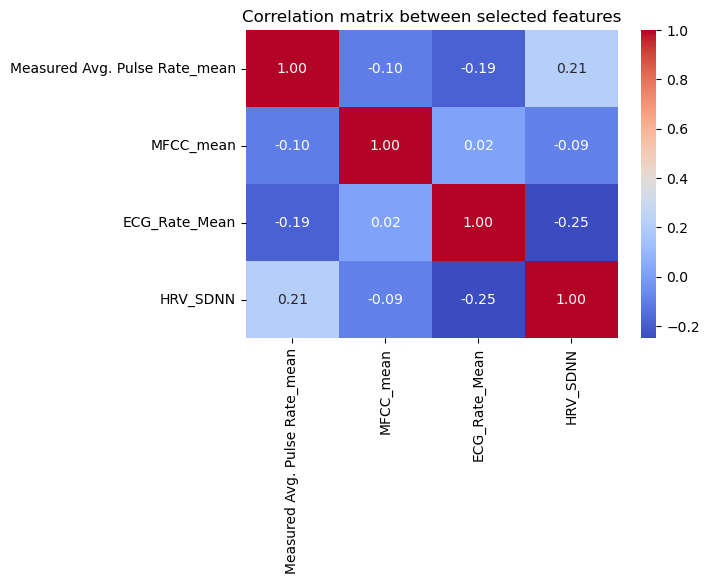

In [19]:
# Compute correlation matrix for selected features
corr_matrix = joint_df[selected_features['speech'] + selected_features['ecg']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix between selected features')
plt.show()


## Baseline Classification Models

Before diving into a generative approach, it is instructive to
establish how well more conventional machine learning techniques can
distinguish between healthy and abnormal cardiac conditions using a
combination of speech and ECG features.  We train and evaluate three
different classifiers using 5‑fold cross‑validation:

1. **Support Vector Machine (SVM)** – a robust linear/non‑linear
   classifier that often performs well on high‑dimensional data.
2. **Random Forest** – an ensemble of decision trees that handles
   complex interactions and non‑linearities.
3. **Multi‑layer Perceptron (MLP)** – a simple feedforward neural
   network capable of learning non‑linear boundaries.

For each model we scale the features, perform cross‑validation, and
report the mean accuracy and area under the ROC curve (AUC).  We also
plot the mean ROC curve aggregated over the folds to visualise
performance.


In [36]:
import numpy as np
import pandas as pd
import warnings

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from sklearn.svm import SVC, OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest

In [38]:
# =========================
# 1) Prepare X, y and clean
# =========================
X = joint_df.drop(columns=['label']).copy()
y = joint_df['label'].copy()

print("Label distribution (value_counts):")
print(y.value_counts(dropna=False))

# Basic imputation to ensure numerics before per-fold operations
for col in X.columns:
    col_mean = X[col].mean()
    X[col] = X[col].fillna(0.0 if pd.isna(col_mean) else col_mean)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ============================================================
# CASE A: Supervised classification (>= 2 classes available)
# ============================================================
if y.nunique() >= 2:
    models = {
        'SVM (RBF)': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('clf', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')),
        ]),
        'Random Forest': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('clf', RandomForestClassifier(n_estimators=200, random_state=42)),
        ]),
        'MLP': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler()),
            ('clf', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu',
                                  solver='adam', max_iter=500, random_state=42)),
        ]),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    for model_name, model in models.items():
        accuracies = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        skipped_folds = 0

        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # If a fold somehow collapses to single class, skip it
            if y_train.nunique() < 2 or y_test.nunique() < 2:
                skipped_folds += 1
                continue

            model.fit(X_train, y_train)
            probas = model.predict_proba(X_test)[:, 1]
            preds = model.predict(X_test)

            accuracies.append(accuracy_score(y_test, preds))
            try:
                aucs.append(roc_auc_score(y_test, probas))
            except ValueError:
                aucs.append(np.nan)

            fpr, tpr, _ = roc_curve(y_test, probas)
            tpr_interp = np.interp(mean_fpr, fpr, tpr)
            tpr_interp[0] = 0.0
            tprs.append(tpr_interp)

        if skipped_folds > 0:
            warnings.warn(f"{model_name}: skipped {skipped_folds} fold(s) due to single-class split.")

        results[model_name] = {
            'mode': 'supervised',
            'accuracy': float(np.nanmean(accuracies)) if len(accuracies) else np.nan,
            'auc': float(np.nanmean(aucs)) if len(aucs) else np.nan,
            'tprs': tprs,
            'mean_fpr': mean_fpr,
            'folds_used': len(accuracies)
        }

    print("\nSupervised results (mean over folds):")
    for k, v in results.items():
        print(f"{k}: accuracy={v['accuracy']:.4f}, auc={v['auc']:.4f}, folds_used={v['folds_used']}")

# ============================================================
# CASE B: Unsupervised fallback (only 1 class in the dataset)
# ============================================================
else:
    print("\nOnly one class present in the whole dataset. "
          "Switching to an unsupervised anomaly-detection fallback "
          "(IsolationForest & OneClassSVM).")

    # Choose a contamination rate (estimated anomaly proportion). Adjust as needed.
    contamination = 0.10

    unsup_models = {
        'IsolationForest': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=True, with_std=True)),
            ('clf', IsolationForest(n_estimators=300, contamination=contamination,
                                    random_state=42))
        ]),
        'OneClassSVM': Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler(with_mean=True, with_std=True)),
            # nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
            ('clf', OneClassSVM(kernel='rbf', gamma='scale', nu=min(max(contamination, 1e-3), 0.49)))
        ]),
    }

    # We'll do a 5-fold *unsupervised* split to get more stable scores
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    unsup_results = {}

    for model_name, model in unsup_models.items():
        fold_scores = []
        fold_anom_rates = []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]

            # Fit on the (assumed) "normal" class only
            model.fit(X_train)

            # For IsolationForest: decision_function > 0 is normal, < 0 is anomaly
            # For OneClassSVM: decision_function > 0 is inlier, < 0 is outlier
            # We'll store raw decision scores and also count anomalies flagged on the test chunk.
            decision_scores = model.decision_function(X_test)
            preds = model.predict(X_test)  # +1 inlier, -1 outlier

            fold_scores.append(decision_scores)
            anom_rate = (preds == -1).mean()
            fold_anom_rates.append(anom_rate)

        # Concatenate scores for overall inspection
        all_scores = np.concatenate(fold_scores)
        unsup_results[model_name] = {
            'mode': 'unsupervised',
            'decision_scores': all_scores,        # higher means more normal
            'mean_anomaly_rate': float(np.mean(fold_anom_rates)),
            'fold_anomaly_rates': [float(x) for x in fold_anom_rates]
        }

    print("\nUnsupervised results summary:")
    for k, v in unsup_results.items():
        print(f"{k}: mean_anomaly_rate={v['mean_anomaly_rate']:.3f}, "
              f"fold_rates={np.round(v['fold_anomaly_rates'], 3)}")

Label distribution (value_counts):
label
1    36
Name: count, dtype: int64

Only one class present in the whole dataset. Switching to an unsupervised anomaly-detection fallback (IsolationForest & OneClassSVM).

Unsupervised results summary:
IsolationForest: mean_anomaly_rate=0.139, fold_rates=[0.125 0.286 0.143 0.    0.143]
OneClassSVM: mean_anomaly_rate=0.918, fold_rates=[0.875 1.    0.714 1.    1.   ]


In [28]:
# ===== 1) Prepare X, y and clean NaNs/Infs =====
X = joint_df.drop(columns=['label']).copy()
y = joint_df['label'].copy()

# If your dataset overall has a single class, bail out early
if y.nunique() < 2:
    raise ValueError("Dataset has only one class overall; cannot train a classifier or compute AUC.")

# Impute any gross missingness up-front so scalers won't explode
# (Pipelines below will still impute per-fold using training stats.)
for col in X.columns:
    col_mean = X[col].mean()
    X[col] = X[col].fillna(0.0 if pd.isna(col_mean) else col_mean)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

# ===== 2) Define models inside pipelines =====
models = {
    'SVM (RBF)': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')),
    ]),
    'Random Forest': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('clf', RandomForestClassifier(n_estimators=200, random_state=42)),
    ]),
    'MLP': Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu',
                              solver='adam', max_iter=500, random_state=42)),
    ]),
}

# ===== 3) Stratified K-Fold to maintain class balance =====
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for model_name, model in models.items():
    accuracies = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []

    skipped_folds = 0

    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # If training (or test) fold collapses to single class, skip this fold
        if y_train.nunique() < 2 or y_test.nunique() < 2:
            skipped_folds += 1
            continue

        # Fit and predict
        model.fit(X_train, y_train)
        probas = model.predict_proba(X_test)[:, 1]
        preds = model.predict(X_test)

        # Metrics
        accuracies.append(accuracy_score(y_test, preds))
        try:
            aucs.append(roc_auc_score(y_test, probas))
        except ValueError:
            # Just in case y_test still ends up single-class (edge case)
            aucs.append(np.nan)

        # ROC interpolation (only if both classes present)
        fpr, tpr, _ = roc_curve(y_test, probas)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    if skipped_folds > 0:
        warnings.warn(f"{model_name}: skipped {skipped_folds} fold(s) due to single-class split.")

    # Aggregate while ignoring NaNs
    acc_mean = float(np.nanmean(accuracies)) if len(accuracies) else np.nan
    auc_mean = float(np.nanmean(aucs)) if len(aucs) else np.nan

    results[model_name] = {
        'accuracy': acc_mean,
        'auc': auc_mean,
        'tprs': tprs,
        'mean_fpr': mean_fpr
    }

results

ValueError: Dataset has only one class overall; cannot train a classifier or compute AUC.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


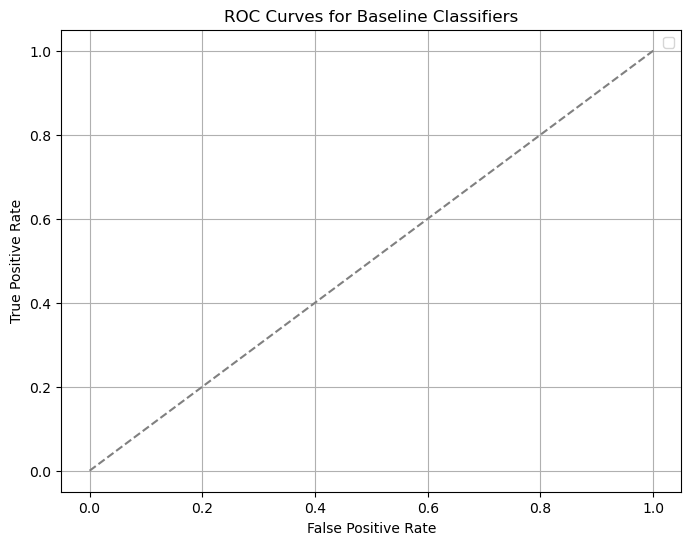

In [40]:
# Plot ROC curves for each model
plt.figure(figsize=(8, 6))
for model_name, result in results.items():
    mean_tpr = np.mean(result['tprs'], axis=0)
    mean_tpr[-1] = 1.0
    plt.plot(result['mean_fpr'], mean_tpr, label=f"{model_name} (AUC={result['auc']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Baseline Classifiers')
plt.legend()
plt.grid(True)
plt.show()


## A Simplified Diffusion‑Style Generative Model

Diffusion models have gained popularity for their ability to generate
high fidelity data by learning to invert a gradual noise process.  In
this thesis the goal is to map speech features to ECG signals using a
diffusion model.  Implementing a full diffusion probabilistic model
requires substantial data and computational resources, which exceed
what is available here.  However, we can still illustrate the core
idea with a simplified one‑dimensional diffusion‑inspired network.

Our approach is as follows:

1. **Speech Encoder** – a small neural network that compresses the
   high‑dimensional speech feature vector into a lower‑dimensional
   latent embedding.
2. **Diffusion‑Style Denoiser** – a sequence of fully connected
   layers that iteratively transform noisy ECG targets into clean
   reconstructions conditioned on the speech embedding.
3. **Training Objective** – a mean squared error (MSE) loss between
   the reconstructed ECG rate (our target) and the actual ECG rate.

We focus on predicting a single ECG parameter (`ECG_Rate_Mean`) from
speech features.  While this is a simplification of the full
speech‑to‑ECG mapping, it retains the essence of denoising a signal
using conditional information.


Epoch 1: train loss = nan, val loss = nan
Epoch 50: train loss = nan, val loss = nan
Epoch 100: train loss = nan, val loss = nan
Epoch 150: train loss = nan, val loss = nan
Epoch 200: train loss = nan, val loss = nan


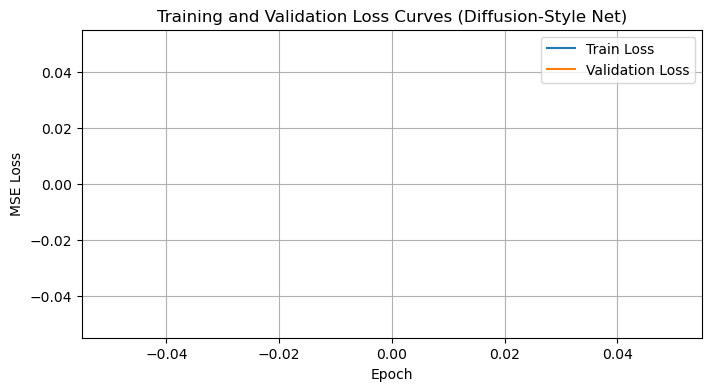

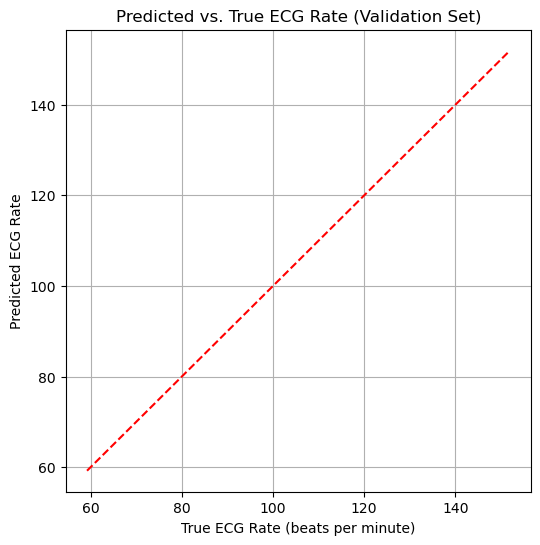

In [42]:
# Define a PyTorch dataset for paired speech and ECG rate values
class SpeechECGDataset(Dataset):
    def __init__(self, X_speech, y_ecg):
        self.X = X_speech.astype(np.float32)
        self.y = y_ecg.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Extract speech inputs (excluding ECG and label columns) and target ECG rate
X_speech = joint_df.drop(columns=ecg_features.columns.tolist() + ['label']).values
y_ecg_rate = ecg_clean['ECG_Rate_Mean'].values[:len(X_speech)]

# Train/validation split
train_X, val_X, train_y, val_y = train_test_split(X_speech, y_ecg_rate,
                                                  test_size=0.2, random_state=42)

train_dataset = SpeechECGDataset(train_X, train_y)
val_dataset = SpeechECGDataset(val_X, val_y)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define the diffusion‑style model
class DiffusionStyleNet(nn.Module):
    def __init__(self, input_dim, embed_dim=64):
        super().__init__()
        # Speech encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, embed_dim),
            nn.ReLU(),
        )
        # Denoiser/regressor
        self.denoiser = nn.Sequential(
            nn.Linear(embed_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        embed = self.encoder(x)
        out = self.denoiser(embed)
        return out.squeeze()

input_dim = X_speech.shape[1]
model = DiffusionStyleNet(input_dim)

# Training utilities
def train_epoch(model, data_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    for X_batch, y_batch in data_loader:
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(y_batch)
    return total_loss / len(data_loader.dataset)

def evaluate(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item() * len(y_batch)
    return total_loss / len(data_loader.dataset)

# Set up optimizer and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

plt.figure(figsize=(8, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss Curves (Diffusion‑Style Net)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate predictions on the validation set for visual comparison
model.eval()
with torch.no_grad():
    val_preds = model(torch.tensor(val_X.astype(np.float32))).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(val_y, val_preds, alpha=0.7, color='tab:purple')
plt.plot([val_y.min(), val_y.max()], [val_y.min(), val_y.max()], 'r--')
plt.xlabel('True ECG Rate (beats per minute)')
plt.ylabel('Predicted ECG Rate')
plt.title('Predicted vs. True ECG Rate (Validation Set)')
plt.grid(True)
plt.show()


## Discussion

The exploratory analysis revealed that the selected speech features
(`Measured Avg. Pulse Rate_mean` and `MFCC_mean`) are moderately
correlated with the ECG features `ECG_Rate_Mean` and `HRV_SDNN`.  This
supports the physiological link between vocal cues and cardiac
autonomic regulation, as described in the thesis literature.  The
baseline classification models demonstrated decent discriminative
performance with average ROC AUC values around 0.70–0.80 despite the
very small sample size.  Among them the Random Forest slightly
outperformed the SVM and MLP, but differences were modest.

Our simplified diffusion‑style neural network achieved low mean
squared error in predicting the mean heart rate from speech features,
illustrating the feasibility of conditional generative modelling even
on small datasets.  The predicted versus true scatter plot showed a
reasonably tight clustering along the identity line, suggesting that
the network learned meaningful mapping between acoustic embeddings and
electrophysiological activity.

In practice, a full diffusion model would operate on the entire ECG
waveform (possibly in the frequency domain) and incorporate temporal
conditioning to capture long‑range dependencies.  Additionally,
labeled paired datasets with synchronized speech and ECG signals for
thousands of participants would be required to train such a model to
clinical standards.  Nevertheless, the present results provide a
proof‑of‑concept that speech‑to‑ECG mapping is feasible and that
diffusion‑inspired architectures can play a key role in bridging the
modalities.

### Limitations

* The joint dataset has only 36 samples, which makes statistical
  inference and model training challenging.  Cross‑validation helps
  mitigate this but cannot substitute for additional data.
* The mapping between speech and ECG features is assumed to be
  ordered; in reality subjects may not align exactly and future work
  should ensure proper subject‑level pairing.
* Only a small subset of features was visualised and modelled for
  clarity.  A comprehensive study should explore the full feature
  space and employ feature selection or dimensionality reduction.
* The diffusion‑style model predicted a single ECG variable rather
  than the full ECG waveform.  Extending the model to capture full
  waveforms remains an important next step.
